## Exploring the CIFAR10 Dataset

<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" style="max-width:480px">

In [11]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [12]:
project_name='05-cifar10-cnn'

In [13]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

In [14]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [15]:
data_dir = "./data/cifar10"
print(os.listdir(data_dir))

classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['deer', 'truck', 'ship', 'automobile', 'horse', 'cat', 'frog', 'dog', 'bird', 'airplane']


Let's look inside a couple of folders, one from the training set and another from the test set.

In [16]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['1180.png', '2066.png', '0986.png', '0125.png', '3551.png']


In [17]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['0986.png', '0125.png', '0671.png', '0445.png', '0287.png']


In [18]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [19]:
dataset = ImageFolder(data_dir + "/train" , transform = ToTensor())

Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of 32x32 px color images with 3 channels (RGB), each image tensor has the shape `(3, 32, 32)`.

In [20]:
img , label = dataset[0]
print(img.shape , label)

torch.Size([3, 32, 32]) 0


In [21]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


We can view the image using `matplotlib`, but we need to change the tensor dimensions to `(32,32,3)`. Let's create a helper function to display an image and its label.

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img , label):
  print("Label :" , dataset.classes[label]  , "(" + str(label)+ ")")
  plt.imshow(img.permute(1 , 2 , 0))

Let's look at a couple of images from the dataset. The 32x32px images are quite difficult to identify, even for the human eye. Try changing the indices below to view different images.

Label : airplane (0)


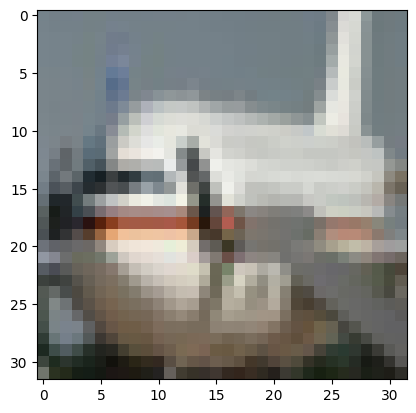

In [23]:
show_example(*dataset[344])

# **Training and Validation Datasets**

Split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set, we can set aside a small portion (5000 images) of the training set to be used as the validation set. We'll use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [24]:
random_seed = 42
torch.manual_seed(random_seed)

In [25]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds , val_ds = random_split(dataset , [train_size , val_size])
len(train_ds)  , len(val_ds)

(45000, 5000)

We can now create data loaders for training and validation, to load the data in batches

In [26]:
from torch.utils.data.dataloader import DataLoader
batch_size = 128

In [27]:
train_dl = DataLoader(train_ds , batch_size , shuffle = True , num_workers=4 , pin_memory=True)
val_dl = DataLoader(val_ds , batch_size*2 , num_workers=4 , pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


We can look at batches of images from the dataset using the `make_grid` method from `torchvision`. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [28]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

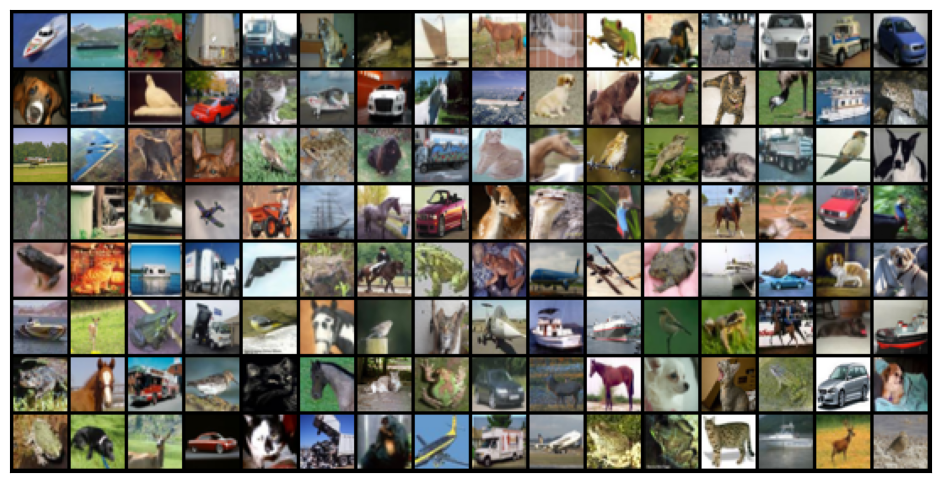

In [29]:
show_batch(train_dl)

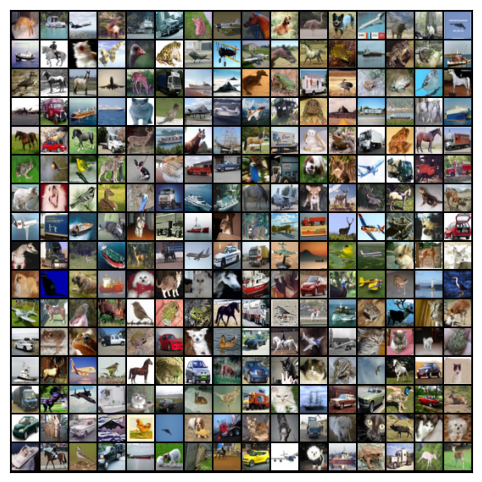

In [30]:
show_batch(val_dl)

# **Defining the Model (Convolutional Neural Network)**


> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel.

Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.

In [31]:
def apply_kernel(image , kernel):
  ri , ci = image.shape
  rk , ck = kernel.shape
  ro , co = ri-rk+1 , ci-ck+1
  output = torch.zeros([ro , co])
  for i in range(ro):
    for j in range(co):
      output[i , j] = torch.sum(image[i:i+rk , j:j+ck] * kernel)
  return output

In [32]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0],
    [0, 0, 1, 3, 1],
    [3, 1, 2, 2, 3],
    [2, 0, 0, 2, 2],
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2],
    [2, 2, 0],
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])


There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer.
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a [max-pooling] layers to progressively decrease the height & width of the output tensors from each convolutional layer.

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">

Before we define the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.

In [33]:
import torch.nn as nn
import torch.nn.functional as F

In [34]:
simple_model = nn.Sequential(
    nn.Conv2d(3,8,kernel_size=3 , stride = 1  , padding =1),
    nn.MaxPool2d(2,2)
)

In [35]:
for images , label in train_dl:
  print("image.shape:" , images.shape)
  out = simple_model(images)
  print("After applying convo layer: ")
  print("out.shape:" , out.shape)
  break


image.shape: torch.Size([128, 3, 32, 32])
After applying convo layer: 
out.shape: torch.Size([128, 8, 16, 16])


The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [36]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [37]:
class Cifar10CnnModel(ImageClassificationBase):

  def __init__(self):
    super().__init__()

    self.network = nn.Sequential(
        #  input - 3 x 32 x 32
        nn.Conv2d(3,32, kernel_size=3 , padding  = 1) ,
        # output 32 x 32 32
        nn.ReLU(),
        # output 32 x 32 32
        nn.Conv2d(32 , 64 , kernel_size = 3 , stride = 1 , padding = 1) ,
        nn.ReLU(),
        # 64  x 32 x 32
        nn.MaxPool2d(2,2), # output - 64 x 16 x 16

        # input 64 x 16 x 16
        nn.Conv2d(64 , 128 ,kernel_size=3 , stride= 1 , padding = 1),
        nn.ReLU(),
        # output 128 x 16 x 16
        nn.Conv2d(128 , 128 , kernel_size = 3 , stride = 1 , padding = 1),
        nn.ReLU(),
        # output 128 x 16 x 16
        nn.MaxPool2d(2,2) , # output 128 x 8 x 8

        # input 128  x 8 x 8
        nn.Conv2d(128 , 256 , kernel_size=3 , stride = 1 , padding = 1),
        nn.ReLU(),
        # output  256 x 8  x 8
        nn.Conv2d(256 , 256  , kernel_size=3 , stride  = 1 , padding=1),
        nn.ReLU(),
        # output 256 x 8 x 8
        nn.MaxPool2d(2,2), # output 256 x 4 x 4

        #  convert it into 1D
        nn.Flatten(),
        nn.Linear(256 * 4 * 4 , 1024),
        nn.ReLU(),
        nn.Linear(1024 , 512),
        nn.ReLU(),
        nn.Linear(512 , 10),


  )

  def forward(self , xb):
      return self.network(xb)

In [38]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [39]:
for images , labels in train_dl:
  print("images.shape :" , images.shape)
  out = model(images)
  print("out.shapes: " , out.shape)
  print("out[0]:" , out[0])
  break

images.shape : torch.Size([128, 3, 32, 32])
out.shapes:  torch.Size([128, 10])
out[0]: tensor([ 0.0269,  0.0142, -0.0089, -0.0402, -0.0177, -0.0444,  0.0414, -0.0070,
         0.0265,  0.0070], grad_fn=<SelectBackward0>)


In [40]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")


def to_device(data , device):
  if isinstance(data , (list , tuple)):
    return [to_device(x , device) for x in data]
  return data.to(device , non_blocking = True)


class DeviceDataLoader():

  def __init__(self , dl , device):
    self.dl = dl
    self.device = device


  def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

  def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [41]:
device = get_default_device()
device

device(type='cuda')

In [42]:
train_dl = DeviceDataLoader(train_dl , device)
val_dl = DeviceDataLoader(val_dl , device)
to_device(model , device)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

# **Training the Model**

We can use the exact same `fit` and `evaluate` functions

In [43]:
def evaluate(model , val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]

  return model.validation_epoch_end(outputs)


def fit(epochs , lr , model , train_loader  , val_loader ,opt_func = torch.optim.SGD):

  history = []
  optimizer = opt_func(model.parameters() , lr)
  for epoch in range(epochs):
    # Training Phase
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()


    # Validation phase


    result = evaluate(model , val_loader)
    result["train_loss"] = torch.stack(train_losses).mean().item()
    model.epoch_end(epochs , result)
    history.append(result)

  return history


Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [44]:
model = to_device(Cifar10CnnModel() , device)

In [45]:
evaluate(model , val_dl)

{'val_loss': 2.3033082485198975, 'val_acc': 0.0963350161910057}

The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We'll use the following *hyperparmeters* (learning rate, no. of epochs, batch_size etc.) to train our model.

In [46]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [47]:
history = fit(num_epochs , lr , model , train_dl , val_dl , opt_func)

Epoch [10], train_loss: 1.8287, val_loss: 1.5055, val_acc: 0.4460
Epoch [10], train_loss: 1.3015, val_loss: 1.1454, val_acc: 0.5824
Epoch [10], train_loss: 1.0375, val_loss: 0.9806, val_acc: 0.6559
Epoch [10], train_loss: 0.8465, val_loss: 0.8400, val_acc: 0.7016
Epoch [10], train_loss: 0.6969, val_loss: 0.7791, val_acc: 0.7384
Epoch [10], train_loss: 0.5914, val_loss: 0.7237, val_acc: 0.7574
Epoch [10], train_loss: 0.4838, val_loss: 0.7266, val_acc: 0.7586
Epoch [10], train_loss: 0.3920, val_loss: 0.7621, val_acc: 0.7682
Epoch [10], train_loss: 0.3125, val_loss: 0.8725, val_acc: 0.7518
Epoch [10], train_loss: 0.2427, val_loss: 0.8269, val_acc: 0.7706


We can also plot the valdation set accuracies to study how the model improves over time.

In [48]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

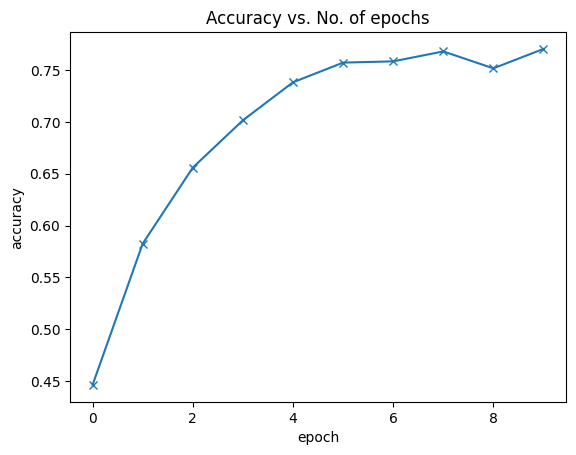

In [49]:
plot_accuracies(history)

Our model reaches an accuracy of around 75%, and by looking at the graph, it seems unlikely that the model will achieve an accuracy higher than 80% even after training for a long time. This suggests that we might need to use a more powerful model to capture the relationship between the images and the labels more accurately. This can be done by adding more convolutional layers to our model, or incrasing the no. of channels in each convolutional layer, or by using regularization techniques.

We can also plot the training and validation losses to study the trend.

In [50]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

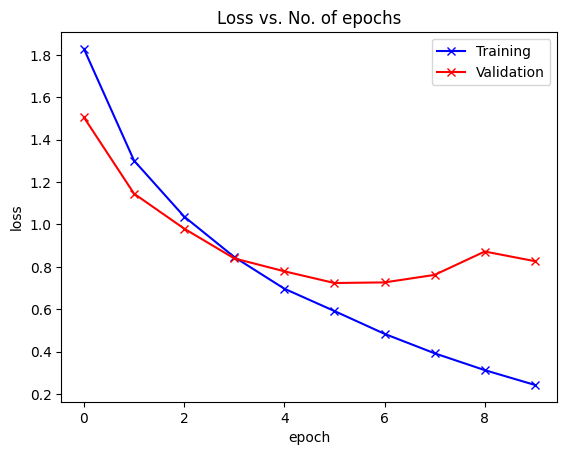

In [51]:
plot_losses(history)

Initialy, both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point!

<img src="https://i.stack.imgur.com/1QU0m.png" style="max-width:400px;">

This phenomenon is called **overfitting**, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patters are are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.


Following are some common technique for avoiding overfitting:

- Gathering and generating more training data, or adding noise to it (Data Augmentation)
- Using regularization techniques like batch normalization & dropout
- Early stopping of model's training, when validation loss starts to increase


# **Testing with individual images**

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by creating a test dataset using the `ImageFolder` class.


In [52]:
from torchvision.datasets import ImageFolder
test_dataset = ImageFolder(data_dir + "/test" , transform=ToTensor())

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [53]:
def predict_image(img , models):
  # convert to a batch 1
  xb = to_device(img.unsqueeze(0) , device)
  # Get predictions from model
  yb = model(xb)
  # Pick index with highest probabailty
  _, preds = torch.max(yb  , dim = 1)
  # Retrive the class label
  return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


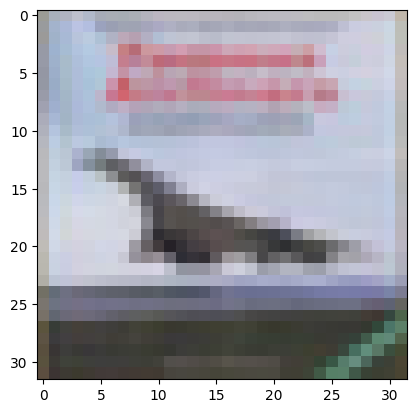

In [54]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

It's very hard to recognize whether image indicate airplace or not through our human eye , But still our model is able to predict the airplane

Label: automobile , Predicted: ship


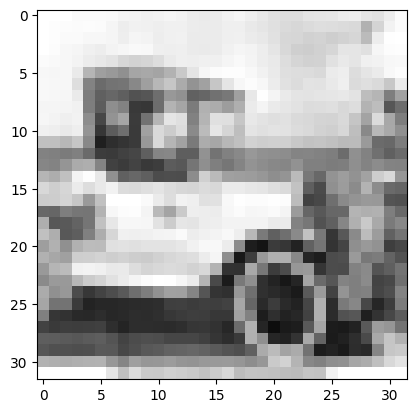

In [57]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Here our model sightly work differently as per dataset image indicate the automobile but our model predict ship , It might possible, beacuse size of automobile and ship sightly same. Accuracy of our model is around 75% still 25% our model can predict wrong label for some images

way to solve this problem?
- Data Augmentaton
- BatchNormalize
- Dropout

Label: frog , Predicted: frog


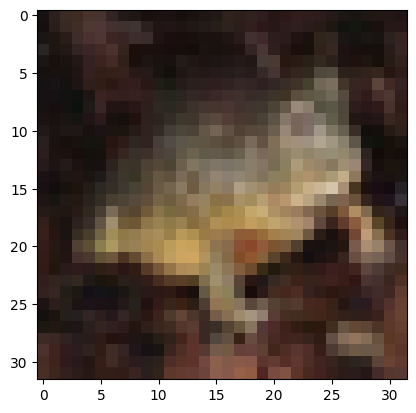

In [58]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [59]:
def predict(input):
  img, label = test_dataset[input]
  plt.imshow(img.permute(1, 2, 0))
  print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: truck , Predicted: truck


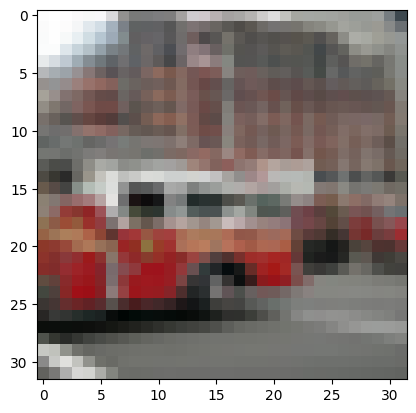

In [68]:
predict(9898)